In [47]:
import numpy as np
import matplotlib.pyplot as plt

In [48]:
def pplot(X, y=[], l=[]):
    if len(y) == 0: y = np.ones(X.shape[0])
    plt.figure(figsize=(6,6))
    plt.xlim(-1, 1) ; plt.ylim(-1, 1)
    _ = plt.plot(X[y>0,0], X[y>0,1], 'bo')
    _ = plt.plot(X[y<0,0], X[y<0,1], 'ro')
    if len(l) > 0: plt.plot(l[0], l[1], 'g', linewidth=3)
    pass

### Generate samples of sufficient norm

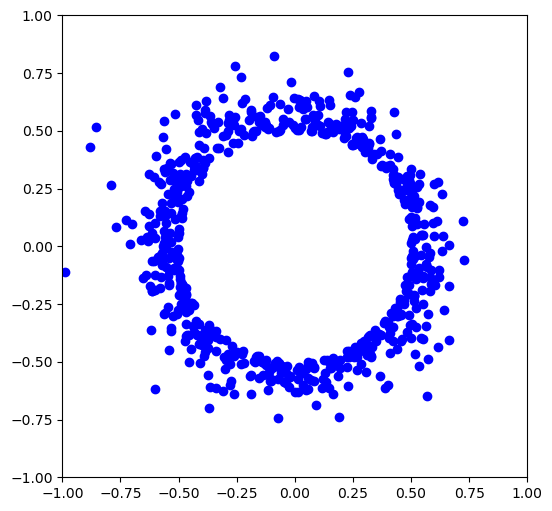

In [49]:
n = 200 ; d = 2
X = np.random.randn(50 * n, d)
nx = np.sqrt(np.sum(X * X, axis=1))
X = X / np.max(nx)
X = X[nx > np.max(nx) / 2,:]
assert X.shape[0] > n, "Increase initial lottery"
pplot(X)

### Choose a random classifier and label samples accordingly

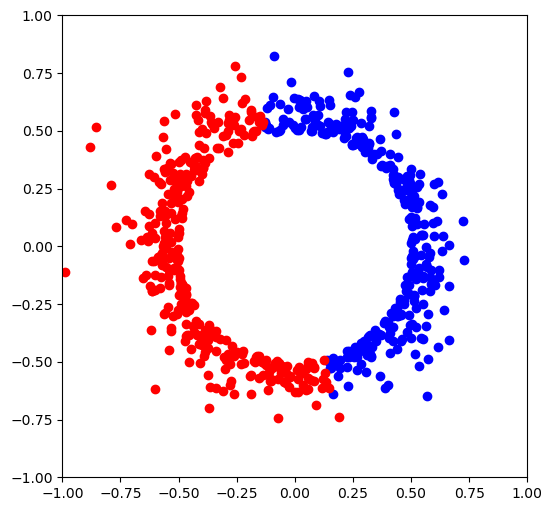

In [50]:
w = np.random.randn(2)
w = w / np.linalg.norm(w)
z = X @ w ; y = np.sign(z)
pplot(X, y)

###  Force sufficient separation of samples

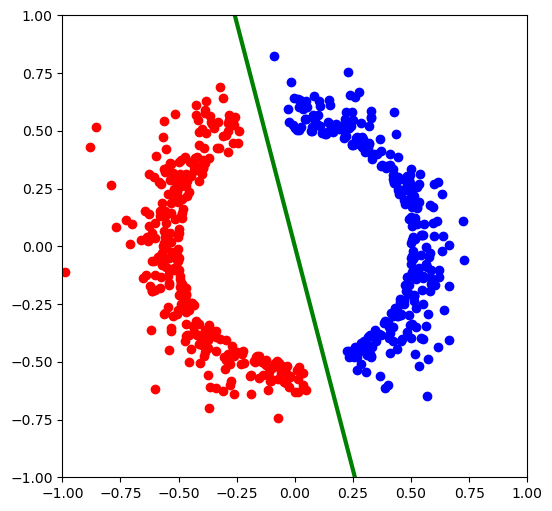

In [51]:
min_margin = 0.1
m = np.where(y * z > min_margin)
X = X[m] ; y = y[m] ; z = z[m]
xe = np.array([-1, 1])
ye = -xe * w[0] / w[1]
pplot(X, y, [xe, ye])

### Convert to probabilities using the probit model

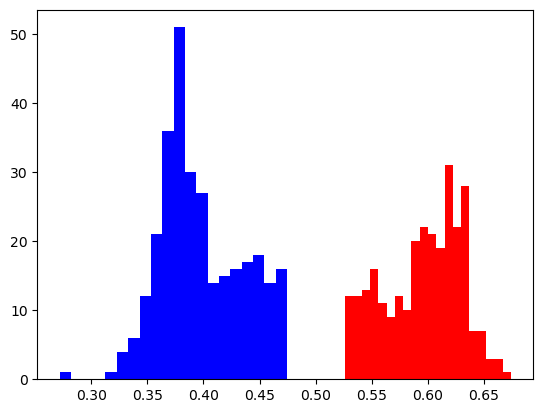

In [52]:
p = 1 / (1 + np.exp(-z))
plt.hist(p[y>0], 20, color='r') ; _ = plt.hist(p[y<0], 20, color='b')

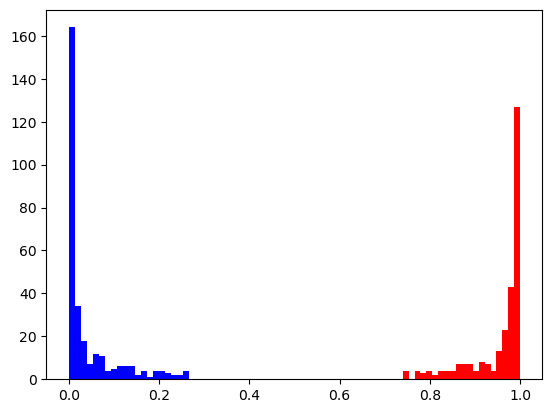

In [53]:
p = 1 / (1 + np.exp(-10 * z))
plt.hist(p[y>0], 20, color='r') ; _ = plt.hist(p[y<0], 20, color='b')

In [54]:
wrep_sampler = lambda n: np.random.choice(n, size=n, replace=True)
nrep_sampler = lambda n: np.random.choice(n, size=n, replace=False)
iter_sampler = lambda n: np.arange(n)
samplers = {'wrep':wrep_sampler, 'nrep':nrep_sampler, 'iter':iter_sampler}
def set_sampler(mode):
    assert samplers.get(mode), "Sampling scheme not defined: " + mode
    print('Using', mode, 'sampling')
    return samplers[mode]

In [60]:
def perceptron(X, y, t=100, mode='nrep'):
    n, d = X.shape
    sampler = set_sampler(mode)
    w, wa, e = np.zeros(d), np.zeros(d), []
    for epoch in range(t):
        for i in iter(sampler(n)):
            if y[i] * np.dot(X[i], w) <= 0:
                w = w + y[i] * X[i]
        wa = (wa * epoch + w) / (epoch + 1)
        e.append(np.mean(y * (X @ wa) <= 0))
        if (epoch + 1) % 10 == 0: print("%3d : %5.2f" % (epoch+1, e[-1] * 100))
        if e[-1] == 0: break
    return w, wa, e

In [61]:
def hdim_data_gen(n, d, sparsity=0, label_noise=0, instance_noise=0):
    serr = lambda z, y: np.mean(y * z <= 0)
    X = np.random.randn(n, d) / np.sqrt(d)
    w = np.random.randn(d) / np.sqrt(d) * np.random.binomial(1, 1-sparsity, d)
    y = np.sign(X @ w)
    X += instance_noise *np.random.randn(n, d) / np.sqrt(d) 
    ei = serr(X @ w, y)
    y *= 2 * np.random.binomial(1, 1 - label_noise, n) - 1
    el = serr(X @ w, y)
    print('Error: %2.0f%% -> %2.0f%%' % (ei * 100, el * 100))
    return X, y, w

In [62]:

X, y, w = hdim_data_gen(10000, 100, sparsity=0.2, label_noise=0.1, instance_noise=0.2)

Error:  6% -> 15%


In [70]:
print('\nPerceptron with replacement:\n' + 28*'-')
w1, a1, e1 = perceptron(X, y, mode='wrep')
print('\nPerceptron without replacement:\n' + 32*'-')
w2, a2, e2 = perceptron(X, y, mode='nrep')
print('\nPerceptron sequential iterator:\n' + 32*'-')
w3, a3, e3 = perceptron(X, y, mode='iter')


Perceptron with replacement:
----------------------------
Using wrep sampling
 10 : 17.95
 20 : 16.82
 30 : 16.50
 40 : 16.51
 50 : 16.35
 60 : 16.32
 70 : 15.99
 80 : 15.77
 90 : 15.88
100 : 15.77

Perceptron without replacement:
--------------------------------
Using nrep sampling
 10 : 18.04
 20 : 16.65
 30 : 16.09
 40 : 16.19
 50 : 16.02
 60 : 16.06
 70 : 15.83
 80 : 15.77
 90 : 15.79
100 : 15.68

Perceptron sequential iterator:
--------------------------------
Using iter sampling
 10 : 25.32
 20 : 24.95
 30 : 24.92
 40 : 24.85
 50 : 24.83
 60 : 24.75
 70 : 24.73
 80 : 24.84
 90 : 24.81
100 : 24.73


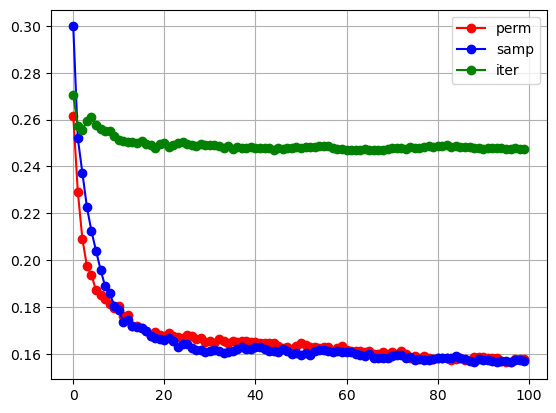

In [71]:
t = np.arange(len(e1))
lo = plt.plot(t, e1, 'r-o', t, e2, 'b-o', t, e3, 'g-o')
plt.legend(iter(lo), ('perm', 'samp', 'iter')); plt.grid()